# Lab3: RL

运行说明：请在notebook环境下运行以看到小车移动的动态效果。notebook文件已上传，命名为`RL.ipynb`

---

实现CartPole小游戏，游戏场景为带有杆的小车，控制小车左右移动以实现以下条件：
1. 杆的偏移角度不超过$15\degree$
2. 小车左右移动距离不超过中间到两边各2.4个单位长度。

## 1 学习场景/环境设计
游戏过程：智能体控制小车左右移动。

游戏结束条件：（以下任一条满足即结束游戏）
- 杆偏移角度 $>15\degree$
- 左右移动距离超过2.4个单位长度
- 坚持时间达到$200$帧（游戏持续最长时间，奖励最大化）

场景设计：
- **state**：$\vec{v} \in R^4$，四维向量，维度含义如下
    |维度|含义|范围|
    |:--:|:--:|:--:|
    |0 | $position$ |$-2.4$~$2.4$|
    |1 | $speed_{car}$|$-inf$~$inf$|
    |2 | $angle$ | $-15\degree$~$15\degree$ |
    |3 | $speed_{top}$ | $-inf$~$inf$|
    
    首先小车当前位置和角度是判断游戏是否结束的关键，因此需要包含在状态中。根据物理原理，实现角度偏移的原因是杆顶部的速度与杆底部和小车相连部分速度不同导致的，小车的角度变化取决于速度差，因此需要包含这两项作为状态向量。
- **action**：二维向量，0表示向左移动，1表示向右移动
- **value**：某一状态获取到的reward的期望。
- **reward**： 游戏坚持1帧没有结束，就收到价值为1的奖励

---

## 2 实现过程
使用一个小型全连接神经网络来训练模型，接受4维状态向量作为输入，输出二维动作向量。

使用经典的`DQN`算法来实现cartpole。

### 2.1 DQN算法伪代码
初始化以下内容:

- 经验回放缓冲区$\mathcal{D}$(experience replay memory)
- Q网络参数$\theta$
- 固定目标网络参数$\theta'$
- $\varepsilon$-greedy参数策略参数$\varepsilon$
- 环境以及环境初始状态s

重复执行以下步骤直到收敛：

1. 选择动作$a$：以$\varepsilon$的概率选择随机初始动作，否则选择Q值最大的动作
2. 执行动作$a$，观察奖励$r$和下一个状态$s'$，存储经验样本$(s,a,r,s')$到缓冲区$\mathcal{D}$ 
3. 从缓冲区$\mathcal{D}$中随机采样一批经验样本，计算目标Q值：

    如果s'是终止状态，$Q = r$
    
    否则，$Q = r+\gamma \times max(Q(s',a',\theta'))$，其中$a'$是从Q网络中选择的动作
4. 将目标Q值和当前Q值的差异作为损失函数，使用梯度下降法更新Q网络的参数$\theta$
5. 更新$\varepsilon$的值

收敛后，返回训练好的Q网络。

> 参数解释：$\gamma$ 表示 `discount factor`，介于0到1之间，reward乘上$\gamma$保证一定收敛。

### 2.2 训练模型与可视化结果
使用以下库完成实验，首先设置好训练环境。

In [1]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1",render_mode="rgb_array")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if cuda is available use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

定义经验回放缓冲区。

In [2]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

定义Q-network模型。

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

定义训练需要的超参数和辅助函数。定义`select_action`函数根据对应的贪心策略从模型中选择下一个动作。

In [4]:
BATCH_SIZE = 128 # the number of samples picked from replay memory
GAMMA = 0.99 # discount factor
EPS_START = 0.9 # start value of epsilon
EPS_END = 0.05 # final value of epsilon
EPS_DECAY = 1000
TAU = 0.005 # update rate of network
LR = 1e-4 # the learning rate using AdamW optimizer

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# use AdamW as optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    '''select an action according to an epsilon greedy policy'''
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure()
    plt.subplot(211)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training Process')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

定义`optimize_model`函数用于实现梯度下降优化模型。

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t)
    # select the columns of actions taken.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

接下来实现完整的训练过程。

1. 初始化环境，获得初始状态。
2. 选择一个action并执行。
3. 获取下一个状态和对应的reward，在经验回放缓冲区存储这一次状态转移。
4. 优化一次模型。


Complete


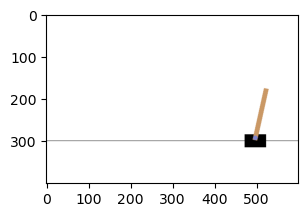

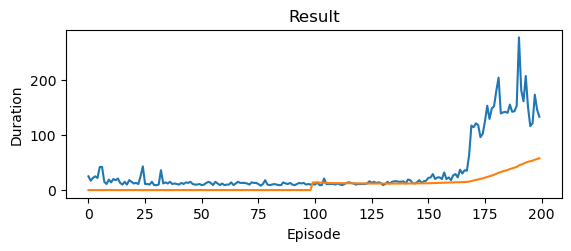

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        # get next state and reward
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    render = lambda: plt.imshow(env.render())
    plt.subplot(212)
    render()
    

print('Complete')
env.close()
plot_durations(show_result=True)
plt.ioff()
plt.show()

----

## 参考资料
1. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
2. https://www.jianshu.com/p/d15090f5a6ea